<a href="https://colab.research.google.com/github/StevenVuong/MSc_Project/blob/master/Step_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This notebook is for analytics**

In [1]:
# standard imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

# to mount our drive
from google.colab import drive

# import keras stuff
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution3D, MaxPooling3D, Convolution1D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils, generic_utils, to_categorical
from keras.layers import LeakyReLU
from keras import regularizers

# to test our dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# mount google drive
drive.mount('/content/gdrive')

os.chdir('/content')

# go to where the data is
print (os.listdir())
os.chdir('gdrive/My Drive/msc_project/all_mprage_grappa')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
['.config', 'gdrive', 'sample_data']


**Get our dataframe**

In [0]:
stored_name = '56_aug_v0'

In [17]:
# read metrics file, format: [val_loss,val_acc, train_loss, train_acc, test_loss, test_acc]
metrics_df = pd.read_csv('stored_metrics/metrics' +stored_name+'.csv', header=None)

# relabel headers
metrics_df.columns = ['val_loss', 'val_acc', 'train_loss', 'train_acc']
metrics_df.head()

,val_loss,val_acc,train_loss,train_acc
0,4.964483,0.6,4.965407,0.568421
1,4.073812,0.8,4.511509,0.578947
2,4.328178,0.6,4.576611,0.505263
3,4.401897,0.4,4.554907,0.558442
4,4.883338,0.2,4.389671,0.578947


In [0]:
# aggregate so we have the averages of each batch (trains on 1 now and tests on 1)
batch_mean_df = metrics_df.groupby(np.arange(len(metrics_df))//4).mean()

# only want to take the last number of epochs we trained for
# now adjusted to 30 because we cut training short
batch_mean_df = batch_mean_df.tail(30)

In [19]:
# get the final output (model at end)
batch_mean_df.iloc[-1,:]

val_loss      1.966557
val_acc       0.650000
train_loss    0.510966
train_acc     0.975701
Name: 29, dtype: float64

**Plot noise and loss for train/test sets** 

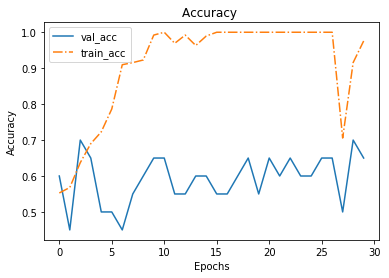

In [20]:
# plotting the accuracy
plt.plot(batch_mean_df.val_acc.values, label='val_acc', ls='-')
plt.plot(batch_mean_df.train_acc.values, label='train_acc', ls='-.')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy ')

plt.legend(loc='best')

plt.show()

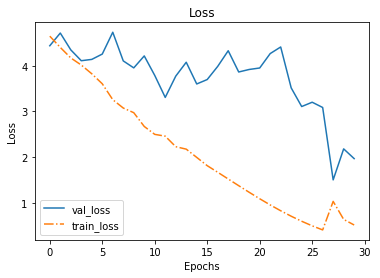

In [21]:
# plotting the loss
plt.plot(batch_mean_df.val_loss.values, label='val_loss', ls='-')
plt.plot(batch_mean_df.train_loss.values, label='train_loss', ls='-.')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')

plt.legend(loc='best')

plt.show()

**Load the model with the final dataset**

In [0]:
# load our pickle batch of data
with open('processed_brains_aug/dbatch4.pkl', 'rb') as f: # also 'total_slices_all.pkl' ## RENAMED 5 TO 7, TESTING IT
  total_slices, total_slices_info = pickle.load(f) # stored_batches/total_slices_batch5
  
# load our model
model = load_model('stored_models/model'+stored_name+'.h5')

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 160, 160, 160, 32) 896       
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 160, 160, 160, 32) 0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 160, 160, 160, 32) 128       
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 80, 80, 80, 32)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 40, 40, 40, 64)    55360     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 40, 40, 40, 64)    0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 40, 40, 40, 64)    256       
__________

In [0]:
# gets our y-values and converts to keras, one hot encoded outputs
def get_y_values(total_slices_info):
  
  y_values = [s[2] for s in total_slices_info]

  y_values = np.array(to_categorical(y_values, 2))
  
  return y_values

In [25]:
np.unique([s[2] for s in total_slices_info], return_counts=True) # look at distribution of patients
# so 55.2% is random, we want better than that for our classifier

(array(['0', '1'], dtype='<U1'), array([32, 26]))

In [0]:
# get y values
y_values = get_y_values(total_slices_info)

# turn into a numpy array
total_slices = np.array(total_slices)

In [0]:
## Build function to load and build score on the fly then aggregate

# Split into smaller chunks so our GPU can handle it
sub_arrays = np.split(total_slices, 29)
sub_y_values = np.split(y_values, 29)

score_sum = []
acc_sum = []
# run through model and test
for i in range(len(sub_arrays)):
  sub_array = sub_arrays[i]
  sub_y_value = sub_y_values[i]
  
  score, acc = model.evaluate(sub_array, sub_y_value)
  score_sum.append(score)
  acc_sum.append(acc)
  
# get average values
mean_score = np.mean(score_sum)
mean_acc = np.mean(acc_sum)

print ("The mean score of the model: %f, The mean accuracy of the model: %f" % (mean_score, mean_acc))

2/2 [==============================] - 7s 3s/step
